In [1]:
import torch
import transformers
import numpy as np
import networkx as nx
import scipy as sp
import scipy.sparse
import matplotlib.pyplot as plt

/home/alokvk2/anaconda3/envs/dl_sys/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
module = getattr(transformers, "BertForSequenceClassification")
model = module.from_pretrained("huggingface/prunebert-base-uncased-6-finepruned-w-distil-mnli")
model

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.31k/1.31k [00:00<00:00, 377kB/s]
Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 438M/438M [00:40<00:00, 10.9MB/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [37]:
query_weights = model.bert.encoder.layer[0].attention.self.query.weight.detach().numpy()
key_weights = model.bert.encoder.layer[0].attention.self.key.weight.detach().numpy()
value_weights = model.bert.encoder.layer[0].attention.self.value.weight.detach().numpy()

In [62]:
attention_adjacency_matrix = np.concatenate((np.zeros_like(query_weights), query_weights, key_weights, value_weights), axis=0).T
A = sp.sparse.lil_matrix((attention_adjacency_matrix.shape[1], attention_adjacency_matrix.shape[1]))
A[:attention_adjacency_matrix.shape[0]] = attention_adjacency_matrix
A = A.tocsr()

In [64]:
G = nx.from_scipy_sparse_array(A)

Text(0, 0.5, 'Frequency')

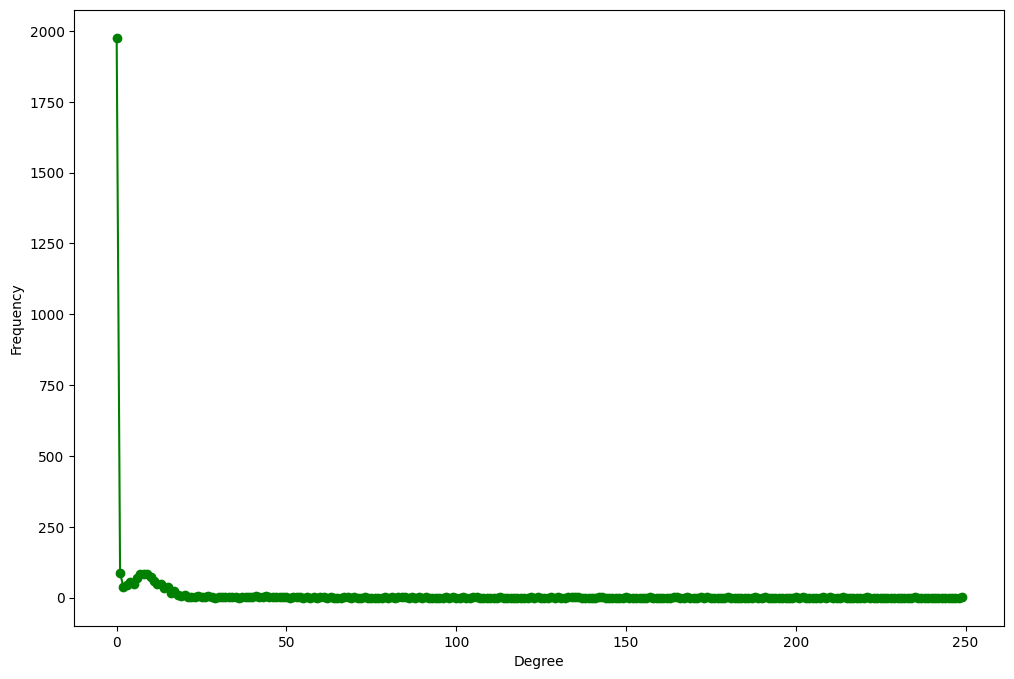

In [70]:
degree_freq = nx.degree_histogram(G)
degrees = range(len(degree_freq))
plt.figure(figsize=(12, 8)) 
plt.plot(degrees, degree_freq,'go-') 
plt.xlabel('Degree')
plt.ylabel('Frequency')

In [72]:
nx.density(G)

0.0019711447139910995

In [76]:
layers = []
layers.append(model.bert.encoder.layer[0].attention.output.dense.weight.detach().numpy())
layers.append(model.bert.encoder.layer[0].intermediate.dense.weight.detach().numpy())
layers.append(model.bert.encoder.layer[0].output.dense.weight.detach().numpy())

In [81]:
A = sp.sparse.lil_matrix(
    (layers[0].shape[1] + sum([l.shape[0] for l in layers]),
    layers[0].shape[1] + sum([l.shape[0] for l in layers])))

cur_row = layers[0].shape[1]
cur_col = 0
for layer in layers:
    A[cur_row:cur_row + layer.shape[0], cur_col: cur_col+layer.shape[1]] = layer
A = A.tocsr()
A.shape

(5376, 5376)

Text(0, 0.5, 'Frequency')

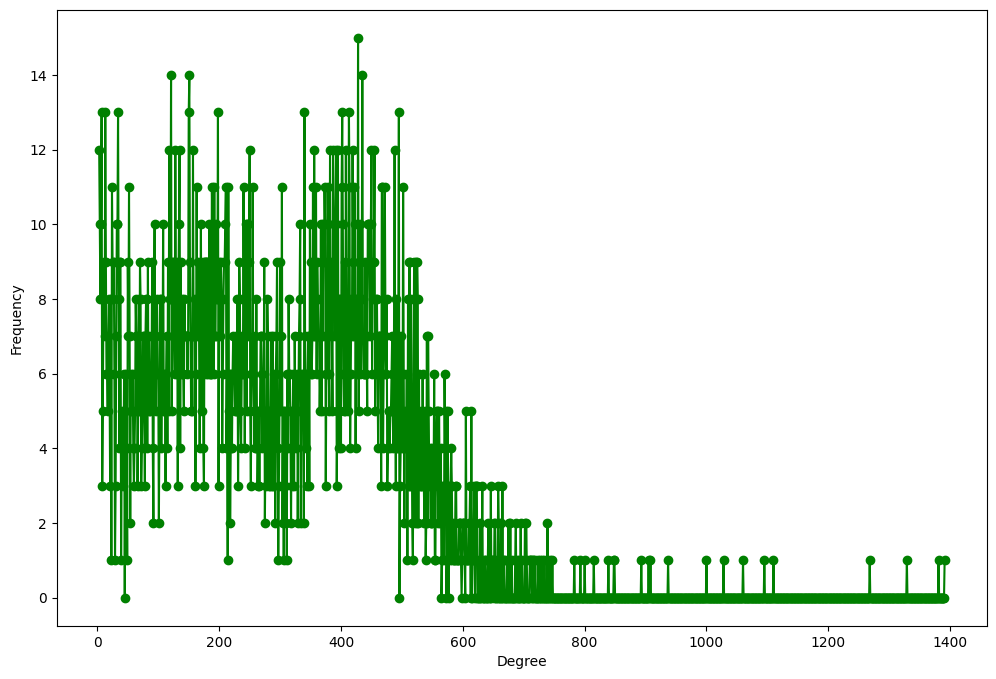

In [82]:
G = nx.from_scipy_sparse_array(A.T)
degree_freq = nx.degree_histogram(G)
degrees = range(len(degree_freq))
plt.figure(figsize=(12, 8)) 
plt.plot(degrees[3:], degree_freq[3:],'go-') 
plt.xlabel('Degree')
plt.ylabel('Frequency')

In [83]:
nx.density(G)

0.03914084994462901